<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[`pyannote.audio`](https://github.com/pyannote/pyannote-audio) is an open-source toolkit written in Python for **speaker diarization**.

Based on [`PyTorch`](https://pytorch.org) machine learning framework, it provides a set of trainable end-to-end neural building blocks that can be combined and jointly optimized to build speaker diarization pipelines.

`pyannote.audio` also comes with pretrained [models](https://huggingface.co/models?other=pyannote-audio-model) and [pipelines](https://huggingface.co/models?other=pyannote-audio-pipeline) covering a wide range of domains for voice activity detection, speaker segmentation, overlapped speech detection, speaker embedding reaching state-of-the-art performance for most of them.

**This notebook will teach you how to apply those pretrained pipelines on your own data.**

Make sure you run it using a GPU (or it might otherwise be slow...)

## Installation

In [1]:
!pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip
!pip install -qq ipython==7.34.0

     | 16.6 MB 5.4 MB/s 0:00:04
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Visualization with `pyannote.core`

For the purpose of this notebook, we will download and use an audio file coming from the [AMI corpus](http://groups.inf.ed.ac.uk/ami/corpus/), which contains a conversation between 4 people in a meeting room.

In [2]:
!wget -q http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2004a/audio/ES2004a.Mix-Headset.wav
DEMO_FILE = {'uri': 'ES2004a.Mix-Headset', 'audio': 'ES2004a.Mix-Headset.wav'}

Because AMI is a benchmarking dataset, it comes with manual annotations (a.k.a *groundtruth*).
Let us load and visualize the expected output of the speaker diarization pipeline.


In [3]:
!wget -q https://raw.githubusercontent.com/pyannote/AMI-diarization-setup/main/only_words/rttms/test/ES2004a.rttm

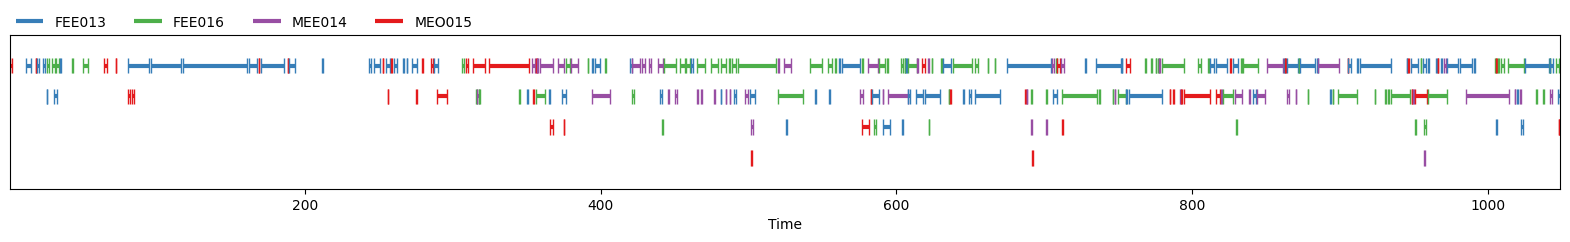

In [4]:
# load groundtruth
from pyannote.database.util import load_rttm
_, groundtruth = load_rttm('ES2004a.rttm').popitem()

# visualize groundtruth
groundtruth

For the rest of this notebook, we will only listen to and visualize a one-minute long excerpt of the file (but will process the whole file anyway).

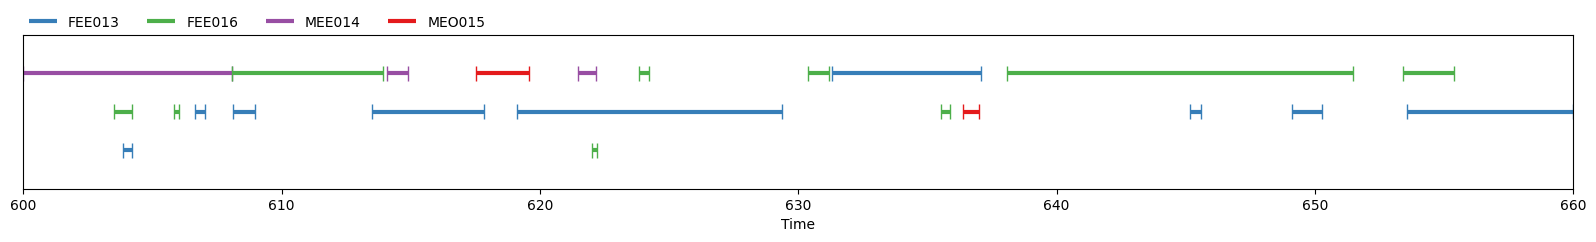

In [5]:
from pyannote.core import Segment, notebook
# make notebook visualization zoom on 600s < t < 660s time range
EXCERPT = Segment(600, 660)
notebook.crop = EXCERPT

# visualize excerpt groundtruth
groundtruth

This nice visualization is brought to you by [`pyannote.core`](http://pyannote.github.io/pyannote-core/) and basically indicates when each speaker speaks.

In [7]:
# !pip3 install pygame

In [8]:
from pyannote.audio import Audio
from IPython.display import Audio as IPythonAudio
waveform, sr = Audio(mono="downmix").crop(DEMO_FILE, EXCERPT)
IPythonAudio(waveform.flatten(), rate=sr)

Output hidden; open in https://colab.research.google.com to view.

# Processing your own audio file (optional)

In case you just want to go ahead with the demo file, skip this section entirely.

In case you want to try processing your own audio file, proceed with running this section. It will offer you to upload an audio file (preferably a `wav` file but all formats supported by [`SoundFile`](https://pysoundfile.readthedocs.io/en/latest/) should work just fine).

## Upload audio file

In [ ]:
import google.colab
own_file, _ = google.colab.files.upload().popitem()
OWN_FILE = {'audio': own_file}
notebook.reset()

# load audio waveform and play it
waveform, sample_rate = Audio(mono="downmix")(OWN_FILE)
IPythonAudio(data=waveform.squeeze(), rate=sample_rate, autoplay=True)

Simply replace `DEMO_FILE` by `OWN_FILE` in the rest of the notebook.

Note, however, that unless you provide a groundtruth annotation in the next cell, you will (obviously) not be able to visualize groundtruth annotation nor evaluate the performance of the diarization pipeline quantitatively

## Upload groundtruth (optional)

The groundtruth file is expected to use the RTTM format, with one line per speech turn with the following convention:

```
SPEAKER {file_name} 1 {start_time} {duration} <NA> <NA> {speaker_name} <NA> <NA>
```

In [ ]:
groundtruth_rttm, _ = google.colab.files.upload().popitem()
groundtruths = load_rttm(groundtruth_rttm)
if OWN_FILE['audio'] in groundtruths:
  groundtruth = groundtruths[OWN_FILE['audio']]
else:
  _, groundtruth = groundtruths.popitem()
groundtruth

# Speaker diarization with `pyannote.pipeline`

We are about to run a full speaker diarization pipeline, that includes speaker segmentation, speaker embedding, and a final clustering step. **Brace yourself!**

To load the speaker diarization pipeline,

* accept the user conditions on [hf.co/pyannote/speaker-diarization](https://hf.co/pyannote/speaker-diarization)
* accept the user conditions on [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation)
* login using `notebook_login` below

In [9]:
!pip install ipywidgets

NotImplementedError: ignored

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization', use_auth_token=True)
diarization = pipeline(DEMO_FILE)

That's it? Yes, that's it :-)

In [ ]:
diarization

# Evaluation with `pyannote.metrics`

Because groundtruth is available, we can evaluate the quality of the diarization pipeline by computing the [diarization error rate](http://pyannote.github.io/pyannote-metrics/reference.html#diarization).

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()
der = metric(groundtruth, diarization)

In [ ]:
print(f'diarization error rate = {100 * der:.1f}%')

This implementation of diarization error rate is brought to you by [`pyannote.metrics`](http://pyannote.github.io/pyannote-metrics/).

It can also be used to improve visualization by find the optimal one-to-one mapping between groundtruth and hypothesized speakers.

In [ ]:
mapping = metric.optimal_mapping(groundtruth, diarization)
diarization.rename_labels(mapping=mapping)

In [ ]:
groundtruth

# Going further

We have only scratched the surface in this introduction.

More details can be found in the [`pyannote.audio` Github repository](https://github.com/pyannote/pyannote-audio).
